In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

In [3]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

print(avDev)

cuda


In [5]:
torch.manual_seed(1)
np.random.seed(1)

In [6]:
len(trainset)

50000

In [7]:
# STEP 2: MAKING DATASET ITERABLE
 
batch_size = 500
n_iters = 5000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)
 
train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=len(testset), 
                                          shuffle=False)
 

In [8]:
'''
STEP 3: CREATE MODEL CLASS
'''
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, 3000)
        self.linear2 = nn.Linear(3000, output_dim)
        self.relu = nn.ReLU()
     
    def forward(self, x):
        out = self.relu(self.linear1(x))
        out = self.linear2(out)
        return out

In [9]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 3*32*32
output_dim = 10
 
model = LogisticRegressionModel(input_dim, output_dim)

In [10]:
#  USE GPU FOR MODEL  #
#######################
 
model.to(avDev)
 
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss().to(avDev)


In [11]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.03
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
'''
STEP 7: TRAIN THE MODEL
'''

loss_save = np.empty(n_iters-1)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
         
        images = images.view(-1, 3*32*32).to(avDev)
        labels = labels.to(avDev)
         
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)#
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
           
        #Save Loss    
        
        loss_save[iter-1] = loss.item()
        iter += 1
        
        if iter % 200 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 3*32*32).to(avDev)
                 
                # Forward pass only to get logits/output
                outputs = model(images)
                 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                correct += (predicted.cpu() == labels.cpu()).sum().float()
             
            accuracy = 100. * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 200. Loss: 1.923643946647644. Accuracy: 36.20000076293945
Iteration: 400. Loss: 1.7451231479644775. Accuracy: 37.959999084472656
Iteration: 600. Loss: 1.7726775407791138. Accuracy: 39.97999954223633
Iteration: 800. Loss: 1.7114512920379639. Accuracy: 38.310001373291016
Iteration: 1000. Loss: 1.6741812229156494. Accuracy: 41.58000183105469
Iteration: 1200. Loss: 1.5091078281402588. Accuracy: 43.68000030517578
Iteration: 1400. Loss: 1.5198075771331787. Accuracy: 44.4900016784668
Iteration: 1600. Loss: 1.566786289215088. Accuracy: 43.599998474121094
Iteration: 1800. Loss: 1.5371806621551514. Accuracy: 44.189998626708984
Iteration: 2000. Loss: 1.5221049785614014. Accuracy: 45.709999084472656
Iteration: 2200. Loss: 1.517372965812683. Accuracy: 45.36000061035156
Iteration: 2400. Loss: 1.5227962732315063. Accuracy: 47.06999969482422
Iteration: 2600. Loss: 1.4845796823501587. Accuracy: 46.61000061035156
Iteration: 2800. Loss: 1.5147380828857422. Accuracy: 47.790000915527344
Iteratio

In [13]:
correct = 0
total = 0
model.to(avDev)

with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 3*32*32).to(avDev)
        labels = labels.to(avDev)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the  train images: 53 %


In [14]:
print(images.size())

torch.Size([500, 3072])


In [15]:
outputs.size()

torch.Size([500, 10])

In [16]:
labels.size()

torch.Size([500])

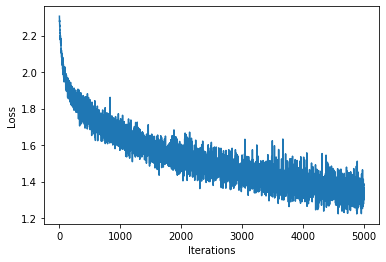

In [17]:
ax = sns.lineplot(data = loss_save)
ax.set(xlabel = "Iterations", ylabel="Loss")
plt.show()

In [18]:
model.to(avDev)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.view(-1, 3*32*32).to(avDev)
        labels = labels.to(avDev)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
cm = confusion_matrix(predicted.cpu(), labels.cpu()).astype(np.int)

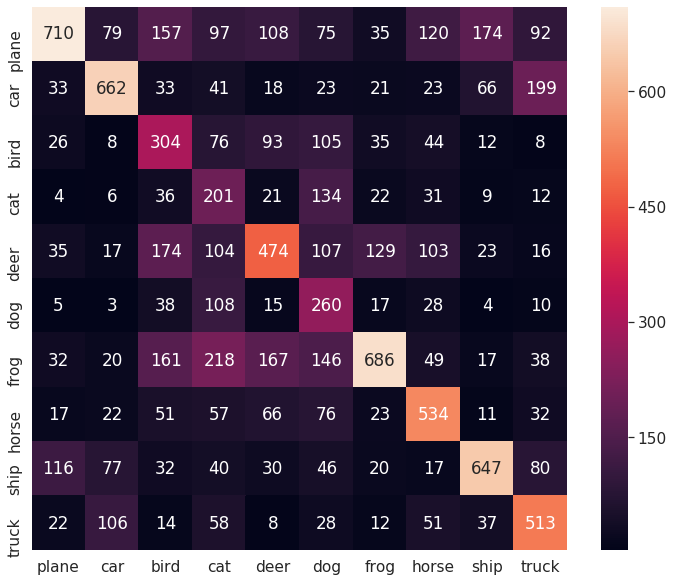

In [19]:
import pandas as pd
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(12,10))
df_cm = pd.DataFrame(cm,CLASSES,CLASSES)
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm,annot=True,fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()